In [1]:
# --- Drive mount (safe to run locally; Colab will prompt to auth) ---
try:
    from google.colab import drive  # type: ignore
    drive.mount("/content/drive", force_remount=False)
    IN_COLAB = True
except Exception:
    IN_COLAB = False

from pathlib import Path
import os

# Set your dataset path here
# Examples:
# DATA_FILE = Path("/content/drive/MyDrive/StudentsPerformance.csv")
# DATA_FILE = Path("/content/StudentsPerformance.csv")
# DATA_FILE = Path("C:/Users/<you>/Downloads/StudentsPerformance.csv")
DATA_FILE = Path("/content/drive/MyDrive/StudentsPerformance.csv")  # <-- change if needed
assert DATA_FILE.exists(), f"File not found: {DATA_FILE}"

import pandas as pd
df = pd.read_csv(DATA_FILE)
print(df.shape)
df.head()


Mounted at /content/drive
(1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [2]:
# We'll keep everything; it's a compact dataset.
# Rename columns to simpler snake_case for convenience.
df = df.rename(columns={
    "race/ethnicity":"race",
    "parental level of education":"parent_edu",
    "test preparation course":"test_prep",
    "math score":"math",
    "reading score":"reading",
    "writing score":"writing",
})

# Basic sanity
display(df.sample(5, random_state=7))
display(df.isna().mean().rename("missing_rate"))
display(df.describe(include="all").T.head(12))


,gender,race,parent_edu,lunch,test_prep,math,reading,writing
778,female,group A,some college,standard,completed,72,79,82
334,female,group C,bachelor's degree,standard,none,83,93,95
271,male,group C,some college,standard,none,58,49,42
802,female,group E,associate's degree,standard,none,87,94,95
216,female,group E,associate's degree,free/reduced,completed,83,86,88


,missing_rate
gender,0.0
race,0.0
parent_edu,0.0
lunch,0.0
test_prep,0.0
math,0.0
reading,0.0
writing,0.0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,1000,2,female,518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,1000,5,group C,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
parent_edu,1000,6,some college,226,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lunch,1000,2,standard,645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test_prep,1000,2,none,642,NaN,NaN,NaN,NaN,NaN,NaN,NaN
math,1000.0,NaN,NaN,NaN,66.089,15.16308,0.0,57.0,66.0,77.0,100.0
reading,1000.0,NaN,NaN,NaN,69.169,14.600192,17.0,59.0,70.0,79.0,100.0
writing,1000.0,NaN,NaN,NaN,68.054,15.195657,10.0,57.75,69.0,79.0,100.0


In [3]:
import numpy as np

# Coerce numerics in case anything came as strings
for col in ["math","reading","writing"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Check missing and drop rows with NA in critical numeric fields (rare in this dataset)
before = len(df)
df = df.dropna(subset=["math","reading","writing"])
print(f"Dropped {before - len(df)} rows with NA in core scores (if any).")

# Keep a working copy
data = df.copy()


Dropped 0 rows with NA in core scores (if any).


In [4]:
# Composite targets for interpretation (not required for clustering)
data["avg_score"] = data[["math","reading","writing"]].mean(axis=1)

# Discrete performance tiers (for summaries & rule extraction):
# You can tweak cut points; these give roughly balanced bins.
data["perf_band"] = pd.cut(
    data["avg_score"],
    bins=[-np.inf, 60, 75, 90, np.inf],
    labels=["low","mid","high","elite"],
    right=False
)

# Separate features for clustering (numeric + categoricals)
cat_cols = ["gender","race","parent_edu","lunch","test_prep"]
num_cols = ["math","reading","writing"]

X_cat = pd.get_dummies(data[cat_cols], drop_first=True)  # interpretable OHE
X_num = data[num_cols].copy()

# Standardize numerics to equalize scale for KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=num_cols, index=X_num.index)

X = pd.concat([X_num_scaled, X_cat], axis=1)
print(X.shape)
X.head()


(1000, 15)


,math,reading,writing,gender_male,race_group B,race_group C,race_group D,race_group E,parent_edu_bachelor's degree,parent_edu_high school,parent_edu_master's degree,parent_edu_some college,parent_edu_some high school,lunch_standard,test_prep_none
0,0.390024,0.193999,0.391492,False,True,False,False,False,True,False,False,False,False,True,True
1,0.192076,1.427476,1.313269,False,False,True,False,False,False,False,False,True,False,True,False
2,1.577711,1.770109,1.642475,False,True,False,False,False,False,False,True,False,False,True,True
3,-1.259543,-0.833899,-1.583744,True,False,False,False,False,False,False,False,False,False,False,True
4,0.653954,0.605158,0.457333,True,False,True,False,False,False,False,False,True,False,True,True


In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Try a small range of cluster counts and pick the best silhouette
k_candidates = [2,3,4,5,6]
scores = {}
for k in k_candidates:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    score = silhouette_score(X, labels)
    scores[k] = score
    print(f"k={k} → silhouette={score:.4f}")

best_k = max(scores, key=scores.get)
print("Best k by silhouette:", best_k)

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)
data["cluster"] = clusters


k=2 → silhouette=0.2776
k=3 → silhouette=0.1803
k=4 → silhouette=0.1363
k=5 → silhouette=0.1342
k=6 → silhouette=0.1322
Best k by silhouette: 2


math                            reading                         \
              mean median        std count       mean median       std count   
cluster                                                                        
0        53.446512   54.0  10.877606   430  56.076744   58.0  9.520738   430   
1        75.626316   75.0  10.126910   570  79.045614   78.0  8.869174   570   

           writing                          avg_score                       \
              mean median        std count       mean     median       std   
cluster                                                                      
0        54.383721   55.0  10.074742   430  54.635659  56.166667  9.011896   
1        78.366667   77.0   9.006575   570  77.679532  76.333333  8.180104   

               
        count  
cluster        
0         430  
1         570

,gender,race,parent_edu,lunch,test_prep
cluster,,,,,
0,male,group C,high school,standard,none
1,female,group C,associate's degree,standard,none


,avg_score_cluster,lift_vs_overall
cluster,,
0,54.635659,-13.135008
1,77.679532,9.908865


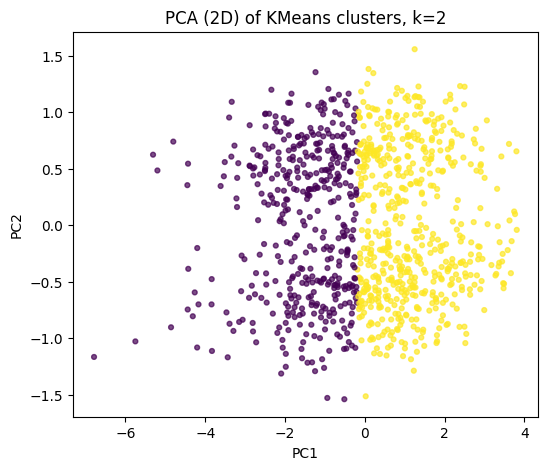

|--- reading <= 61.50
|   |--- math <= 61.50
|   |   |--- writing <= 55.50
|   |   |   |--- class: low
|   |   |--- writing >  55.50
|   |   |   |--- class: low
|   |--- math >  61.50
|   |   |--- class: mid
|--- reading >  61.50
|   |--- reading <= 76.50
|   |   |--- math <= 76.50
|   |   |   |--- class: mid
|   |   |--- math >  76.50
|   |   |   |--- class: high
|   |--- reading >  76.50
|   |   |--- reading <= 91.50
|   |   |   |--- class: high
|   |   |--- reading >  91.50
|   |   |   |--- class: elite



In [7]:
# --- Profile clusters with simple, readable stats ---
profile_num = data.groupby("cluster")[num_cols + ["avg_score"]].agg(["mean","median","std","count"])
profile_cat = data.groupby("cluster")[cat_cols].agg(lambda s: s.value_counts().index[0])  # mode per cluster
display(profile_num)
display(profile_cat)

# Quick lift of avg_score vs overall
overall_avg = data["avg_score"].mean()
lift = data.groupby("cluster")["avg_score"].mean().rename("avg_score_cluster")
lift = pd.concat([lift, (lift - overall_avg).rename("lift_vs_overall")], axis=1)
display(lift)

# --- 2D visualization with PCA (only for visual intuition) ---
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X)
plt.figure(figsize=(6,5))
plt.scatter(X_2d[:,0], X_2d[:,1], c=data["cluster"], s=12, alpha=0.7)
plt.title(f"PCA (2D) of KMeans clusters, k={best_k}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# --- Simple rule extraction: shallow Decision Tree to explain clusters or perf_band ---
# We'll predict perf_band from original features; shallow depth keeps rules human-sized.
from sklearn.tree import DecisionTreeClassifier, export_text

rule_X = pd.get_dummies(data[cat_cols + num_cols], drop_first=True)
rule_y = data["perf_band"]

tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=50, random_state=42)
tree.fit(rule_X, rule_y)
rules = export_text(tree, feature_names=list(rule_X.columns), decimals=2)
print(rules)
